In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [2]:
df = functions.get_all_data_for_train()
df.head()

,Sample,#,Stage,Temp,target
0,1.0,1,4000,126.0,good point
1,NaN,2,2000,106.0,good point
2,NaN,3,1750,104.0,good point
3,NaN,4,1500,102.0,good point
4,NaN,5,1250,100.0,good point


<AxesSubplot:xlabel='Temp', ylabel='Count'>

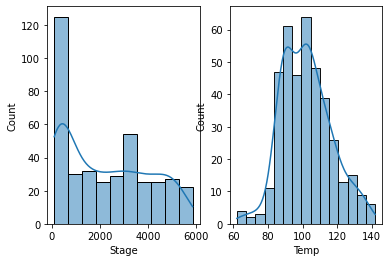

In [3]:
fig, ax = plt.subplots(1, 2)
sns.histplot(df['Stage'], kde=True, ax=ax[0])
sns.histplot(df['Temp'], kde=True, ax=ax[1])

In [4]:
X, y = functions.get_sequences_and_targets(df)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [13]:
y_test

array([1, 0, 0, 1, 0])

In [14]:
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout, SimpleRNN, GRU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Accuracy, Precision, Recall

In [15]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', 
                                                 classes=np.unique(y_train), 
                                                 y=y_train)

In [16]:
class_weight
class_weights = {0: class_weight[0], 1: class_weight[1]}

In [17]:
class_weights

{0: 0.5882352941176471, 1: 3.3333333333333335}

In [18]:
def create_model(output_bias=None, n_layers=1, n_neurons=1, learning_rate=0.005):
    model = Sequential(name=f'{n_layers}_layer_{n_neurons}_cell')
    model.add(BatchNormalization(input_shape=[None, 2]))

    for i in range(n_layers):
        if i == n_layers-1:
            model.add(GRU(n_neurons))
            model.add(BatchNormalization())
            model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(output_bias)))
            break
        model.add(GRU(n_neurons, return_sequences=True))
        model.add(BatchNormalization())

    
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=[Precision(), 'accuracy', Recall()])
    return model
    

In [19]:
tb_callback = TensorBoard(r'./model_logs')
early_stopping = EarlyStopping(restore_best_weights=True, patience=1000)
model_checkpoint = ModelCheckpoint('./best_model', save_best_only=True)

In [20]:
neg, pos = np.bincount(y)
initial_bias = np.log([pos/neg])
initial_bias

array([-1.38629436])

In [21]:
model = create_model(output_bias=initial_bias, n_layers=1, n_neurons=3, learning_rate=0.001)

In [22]:
model.summary()

Model: "1_layer_3_cell"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, None, 2)          8         
 ormalization)                                                   
                                                                 
 gru (GRU)                   (None, 3)                 63        
                                                                 
 batch_normalization_1 (Batc  (None, 3)                12        
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 87
Trainable params: 77
Non-trainable params: 10
_________________________________________________________________


In [23]:
y_test

array([1, 0, 0, 1, 0])

In [24]:
model.fit(X_train, 
          y_train, 
          epochs=3000, 
          batch_size=20,
          validation_data=(X_test, y_test),
          class_weight=class_weights,
          callbacks=[early_stopping])

Epoch 1/3000
1/1 [==============================] - 15s 15s/step - loss: 1.1882 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.7769 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2/3000
1/1 [==============================] - 0s 162ms/step - loss: 1.1836 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.7773 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 3/3000
1/1 [==============================] - 0s 157ms/step - loss: 1.1789 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.7776 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 4/3000
1/1 [==============================] - 0s 157ms/step - loss: 1.1743 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.7793 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 5/3000
1/1 [=======================

1/1 [==============================] - 0s 171ms/step - loss: 1.0331 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.8193 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 36/3000
1/1 [==============================] - 0s 182ms/step - loss: 1.0287 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.8175 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 37/3000
1/1 [==============================] - 0s 153ms/step - loss: 1.0242 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.8157 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 38/3000
1/1 [==============================] - 0s 77ms/step - loss: 1.0197 - precision: 0.0000e+00 - accuracy: 0.7500 - recall: 0.0000e+00 - val_loss: 0.8139 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 39/3000
1/1 [==============================] 

1/1 [==============================] - 0s 100ms/step - loss: 0.8823 - precision: 0.0000e+00 - accuracy: 0.8000 - recall: 0.0000e+00 - val_loss: 0.7642 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 70/3000
1/1 [==============================] - 0s 97ms/step - loss: 0.8778 - precision: 0.0000e+00 - accuracy: 0.8000 - recall: 0.0000e+00 - val_loss: 0.7630 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 71/3000
1/1 [==============================] - 0s 94ms/step - loss: 0.8733 - precision: 0.0000e+00 - accuracy: 0.8000 - recall: 0.0000e+00 - val_loss: 0.7618 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 72/3000
1/1 [==============================] - 0s 100ms/step - loss: 0.8689 - precision: 0.0000e+00 - accuracy: 0.8000 - recall: 0.0000e+00 - val_loss: 0.7606 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 73/3000
1/1 [==============================] -

1/1 [==============================] - 0s 172ms/step - loss: 0.7439 - precision: 0.0000e+00 - accuracy: 0.8500 - recall: 0.0000e+00 - val_loss: 0.7366 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 104/3000
1/1 [==============================] - 0s 116ms/step - loss: 0.7409 - precision: 0.0000e+00 - accuracy: 0.8500 - recall: 0.0000e+00 - val_loss: 0.7362 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 105/3000
1/1 [==============================] - 0s 189ms/step - loss: 0.7379 - precision: 0.0000e+00 - accuracy: 0.8500 - recall: 0.0000e+00 - val_loss: 0.7358 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 106/3000
1/1 [==============================] - 0s 184ms/step - loss: 0.7351 - precision: 0.0000e+00 - accuracy: 0.8500 - recall: 0.0000e+00 - val_loss: 0.7355 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 107/3000
1/1 [===========================

1/1 [==============================] - 0s 177ms/step - loss: 0.6786 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7289 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 138/3000
1/1 [==============================] - 0s 162ms/step - loss: 0.6774 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7288 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 139/3000
1/1 [==============================] - 0s 141ms/step - loss: 0.6762 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7286 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 140/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.6750 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7284 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 141/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.6

1/1 [==============================] - 0s 181ms/step - loss: 0.6429 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7214 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 173/3000
1/1 [==============================] - 0s 150ms/step - loss: 0.6420 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7211 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 174/3000
1/1 [==============================] - 0s 99ms/step - loss: 0.6412 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7209 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 175/3000
1/1 [==============================] - 0s 104ms/step - loss: 0.6403 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7206 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 176/3000
1/1 [==============================] - 0s 132ms/step - loss: 0.63

1/1 [==============================] - 0s 177ms/step - loss: 0.6145 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7104 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 208/3000
1/1 [==============================] - 0s 119ms/step - loss: 0.6137 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7100 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 209/3000
1/1 [==============================] - 0s 108ms/step - loss: 0.6129 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7097 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 210/3000
1/1 [==============================] - 0s 141ms/step - loss: 0.6122 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.3333 - val_loss: 0.7093 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 211/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.6

1/1 [==============================] - 0s 113ms/step - loss: 0.5891 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6971 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 243/3000
1/1 [==============================] - 0s 84ms/step - loss: 0.5884 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6967 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 244/3000
1/1 [==============================] - 0s 107ms/step - loss: 0.5877 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6963 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 245/3000
1/1 [==============================] - 0s 142ms/step - loss: 0.5870 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6959 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 246/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.58

1/1 [==============================] - 0s 219ms/step - loss: 0.5654 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6824 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 278/3000
1/1 [==============================] - 0s 132ms/step - loss: 0.5647 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6820 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 279/3000
1/1 [==============================] - 0s 107ms/step - loss: 0.5641 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6815 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 280/3000
1/1 [==============================] - 0s 130ms/step - loss: 0.5634 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6811 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 281/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.5

1/1 [==============================] - 0s 199ms/step - loss: 0.5427 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6677 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 313/3000
1/1 [==============================] - 0s 206ms/step - loss: 0.5421 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6673 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 314/3000
1/1 [==============================] - 0s 200ms/step - loss: 0.5414 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6669 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 315/3000
1/1 [==============================] - 0s 207ms/step - loss: 0.5408 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6665 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 316/3000
1/1 [==============================] - 0s 195ms/step - loss: 0.5

1/1 [==============================] - 0s 214ms/step - loss: 0.5201 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6544 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 348/3000
1/1 [==============================] - 0s 199ms/step - loss: 0.5195 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6540 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 349/3000
1/1 [==============================] - 0s 225ms/step - loss: 0.5188 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6537 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 350/3000
1/1 [==============================] - 0s 197ms/step - loss: 0.5182 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6533 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 351/3000
1/1 [==============================] - 0s 111ms/step - loss: 0.5

1/1 [==============================] - 0s 179ms/step - loss: 0.4966 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6431 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 383/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.4959 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6428 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 384/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.4952 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6425 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 385/3000
1/1 [==============================] - 0s 180ms/step - loss: 0.4945 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6423 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 386/3000
1/1 [==============================] - 0s 203ms/step - loss: 0.4

1/1 [==============================] - 0s 85ms/step - loss: 0.4706 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6349 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 418/3000
1/1 [==============================] - 0s 98ms/step - loss: 0.4698 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6347 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 419/3000
1/1 [==============================] - 0s 99ms/step - loss: 0.4690 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6345 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 420/3000
1/1 [==============================] - 0s 102ms/step - loss: 0.4682 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6344 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 421/3000
1/1 [==============================] - 0s 97ms/step - loss: 0.4674 

1/1 [==============================] - 0s 82ms/step - loss: 0.4413 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6328 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 453/3000
1/1 [==============================] - 0s 105ms/step - loss: 0.4404 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6329 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 454/3000
1/1 [==============================] - 0s 96ms/step - loss: 0.4396 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6330 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 455/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.4387 - precision: 0.5000 - accuracy: 0.8500 - recall: 0.6667 - val_loss: 0.6331 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 456/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.437

1/1 [==============================] - 0s 149ms/step - loss: 0.4105 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6416 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 488/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.4096 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6420 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 489/3000
1/1 [==============================] - 0s 100ms/step - loss: 0.4087 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6424 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 490/3000
1/1 [==============================] - 0s 115ms/step - loss: 0.4079 - precision: 0.6667 - accuracy: 0.9000 - recall: 0.6667 - val_loss: 0.6428 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 491/3000
1/1 [==============================] - 0s 114ms/step - loss: 0.40

1/1 [==============================] - 0s 166ms/step - loss: 0.3820 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6564 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 523/3000
1/1 [==============================] - 0s 154ms/step - loss: 0.3813 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6568 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 524/3000
1/1 [==============================] - 0s 109ms/step - loss: 0.3805 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6571 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 525/3000
1/1 [==============================] - 0s 151ms/step - loss: 0.3798 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6574 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 526/3000
1/1 [==============================] - 0s 157ms/step - loss: 0.3

1/1 [==============================] - 0s 158ms/step - loss: 0.3580 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6604 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 558/3000
1/1 [==============================] - 0s 154ms/step - loss: 0.3573 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6602 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 559/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.3567 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6600 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 560/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.3561 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6599 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 561/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.3

1/1 [==============================] - 0s 210ms/step - loss: 0.3369 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6504 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 593/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.3363 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6501 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 594/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.3357 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6498 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 595/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.3351 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6495 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 596/3000
1/1 [==============================] - 0s 164ms/step - loss: 0.3

1/1 [==============================] - 0s 176ms/step - loss: 0.3170 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6480 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 628/3000
1/1 [==============================] - 0s 180ms/step - loss: 0.3164 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6483 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 629/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.3159 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6486 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 630/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.3153 - precision: 0.5000 - accuracy: 0.8500 - recall: 1.0000 - val_loss: 0.6489 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 631/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.3

1/1 [==============================] - 0s 185ms/step - loss: 0.2980 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.6721 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 663/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.2975 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.6732 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 664/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.2970 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.6743 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 665/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.2964 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.6754 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 666/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.2

1/1 [==============================] - 0s 183ms/step - loss: 0.2803 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.7184 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 698/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.2798 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.7199 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 699/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.2793 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.7215 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 700/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.2788 - precision: 0.6000 - accuracy: 0.9000 - recall: 1.0000 - val_loss: 0.7230 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 701/3000
1/1 [==============================] - 0s 192ms/step - loss: 0.2

1/1 [==============================] - 0s 189ms/step - loss: 0.2638 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.7791 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 733/3000
1/1 [==============================] - 0s 227ms/step - loss: 0.2633 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.7810 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 734/3000
1/1 [==============================] - 0s 225ms/step - loss: 0.2629 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.7830 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 735/3000
1/1 [==============================] - 0s 107ms/step - loss: 0.2624 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.7849 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 736/3000
1/1 [==============================] - 0s 78ms/step - loss: 0.26

1/1 [==============================] - 0s 174ms/step - loss: 0.2482 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.8515 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 768/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.2478 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.8537 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 769/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.2474 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.8558 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 770/3000
1/1 [==============================] - 0s 183ms/step - loss: 0.2469 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.8579 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 771/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.2

1/1 [==============================] - 0s 183ms/step - loss: 0.2334 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9219 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 803/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.2329 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9237 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 804/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.2325 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9255 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 805/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.2321 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9272 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 806/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.2

1/1 [==============================] - 0s 182ms/step - loss: 0.2189 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9717 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 838/3000
1/1 [==============================] - 0s 183ms/step - loss: 0.2185 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9727 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 839/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.2181 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9737 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 840/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.2177 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9746 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 841/3000
1/1 [==============================] - 0s 193ms/step - loss: 0.2

1/1 [==============================] - 0s 179ms/step - loss: 0.2047 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9914 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 873/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.2043 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9915 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 874/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.2039 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9916 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 875/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.2035 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9916 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 876/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.2

1/1 [==============================] - 0s 175ms/step - loss: 0.1907 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9778 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 908/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.1903 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9768 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 909/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.1899 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9758 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 910/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.1895 - precision: 0.7500 - accuracy: 0.9500 - recall: 1.0000 - val_loss: 0.9748 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 911/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.1

1/1 [==============================] - 0s 177ms/step - loss: 0.1769 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.9224 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 943/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.1766 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.9201 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 944/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.1762 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.9177 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 945/3000
1/1 [==============================] - 0s 173ms/step - loss: 0.1758 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.9153 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 946/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.1

1/1 [==============================] - 0s 202ms/step - loss: 0.1634 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.8177 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 978/3000
1/1 [==============================] - 0s 197ms/step - loss: 0.1630 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.8141 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 979/3000
1/1 [==============================] - 0s 182ms/step - loss: 0.1626 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.8104 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 980/3000
1/1 [==============================] - 0s 115ms/step - loss: 0.1622 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.8067 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 981/3000
1/1 [==============================] - 0s 93ms/step - loss: 0.16

1/1 [==============================] - 0s 151ms/step - loss: 0.1496 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.6784 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1013/3000
1/1 [==============================] - 0s 164ms/step - loss: 0.1492 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.6742 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1014/3000
1/1 [==============================] - 0s 93ms/step - loss: 0.1488 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.6701 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1015/3000
1/1 [==============================] - 0s 86ms/step - loss: 0.1484 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.6660 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1016/3000
1/1 [==============================] - 0s 98ms/step - loss: 0.

Epoch 1047/3000
1/1 [==============================] - 0s 108ms/step - loss: 0.1353 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5416 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1048/3000
1/1 [==============================] - 0s 105ms/step - loss: 0.1349 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5381 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1049/3000
1/1 [==============================] - 0s 95ms/step - loss: 0.1345 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5347 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1050/3000
1/1 [==============================] - 0s 83ms/step - loss: 0.1341 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5313 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1051/3000
1/1 [==============================] - 0s 81ms

1/1 [==============================] - 0s 80ms/step - loss: 0.1202 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4435 - val_precision: 1.0000 - val_accuracy: 0.8000 - val_recall: 0.5000
Epoch 1083/3000
1/1 [==============================] - 0s 104ms/step - loss: 0.1198 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4416 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1084/3000
1/1 [==============================] - 0s 96ms/step - loss: 0.1193 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4396 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1085/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.1189 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4378 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1086/3000
1/1 [==============================] - 0s 74ms/step - loss: 0.1184 - precision: 1.0000 - accura

1/1 [==============================] - 0s 165ms/step - loss: 0.1041 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4081 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1119/3000
1/1 [==============================] - 0s 166ms/step - loss: 0.1036 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4082 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1120/3000
1/1 [==============================] - 0s 158ms/step - loss: 0.1032 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4083 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1121/3000
1/1 [==============================] - 0s 157ms/step - loss: 0.1027 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4086 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1122/3000
1/1 [==============================] - 0s 111ms/step - loss: 0.1023 - precision: 1.0000 - ac

1/1 [==============================] - 0s 169ms/step - loss: 0.0882 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4440 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1155/3000
1/1 [==============================] - 0s 164ms/step - loss: 0.0877 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4457 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1156/3000
1/1 [==============================] - 0s 156ms/step - loss: 0.0873 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4475 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1157/3000
1/1 [==============================] - 0s 154ms/step - loss: 0.0869 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4493 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1158/3000
1/1 [==============================] - 0s 138ms/step - loss: 0.0865 - precision: 1.0000 - ac

1/1 [==============================] - 0s 156ms/step - loss: 0.0736 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5119 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1191/3000
1/1 [==============================] - 0s 106ms/step - loss: 0.0732 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5136 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1192/3000
1/1 [==============================] - 0s 165ms/step - loss: 0.0728 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5152 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1193/3000
1/1 [==============================] - 0s 160ms/step - loss: 0.0724 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5169 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1194/3000
1/1 [==============================] - 0s 147ms/step - loss: 0.0721 - precision: 1.0000 - ac

1/1 [==============================] - 0s 98ms/step - loss: 0.0614 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5464 - val_precision: 0.5000 - val_accuracy: 0.6000 - val_recall: 1.0000
Epoch 1227/3000
1/1 [==============================] - 0s 116ms/step - loss: 0.0611 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5465 - val_precision: 0.5000 - val_accuracy: 0.6000 - val_recall: 1.0000
Epoch 1228/3000
1/1 [==============================] - 0s 154ms/step - loss: 0.0608 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5465 - val_precision: 0.5000 - val_accuracy: 0.6000 - val_recall: 1.0000
Epoch 1229/3000
1/1 [==============================] - 0s 152ms/step - loss: 0.0605 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5465 - val_precision: 0.5000 - val_accuracy: 0.6000 - val_recall: 1.0000
Epoch 1230/3000
1/1 [==============================] - 0s 84ms/step - loss: 0.0602 - precision: 1.0000 - accu

1/1 [==============================] - 0s 169ms/step - loss: 0.0520 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5211 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1263/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.0518 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5197 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1264/3000
1/1 [==============================] - 0s 84ms/step - loss: 0.0516 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5183 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1265/3000
1/1 [==============================] - 0s 105ms/step - loss: 0.0514 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.5169 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1266/3000
1/1 [==============================] - 0s 95ms/step - loss: 0.0511 - precision: 1.0000 - accu

1/1 [==============================] - 0s 177ms/step - loss: 0.0451 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4635 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1299/3000
1/1 [==============================] - 0s 157ms/step - loss: 0.0450 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4619 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1300/3000
1/1 [==============================] - 0s 113ms/step - loss: 0.0448 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4602 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1301/3000
1/1 [==============================] - 0s 94ms/step - loss: 0.0447 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4586 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1302/3000
1/1 [==============================] - 0s 95ms/step - loss: 0.0445 - precision: 1.0000 - accu

1/1 [==============================] - 0s 159ms/step - loss: 0.0400 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4115 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1335/3000
1/1 [==============================] - 0s 157ms/step - loss: 0.0399 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4104 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1336/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0397 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4093 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1337/3000
1/1 [==============================] - 0s 154ms/step - loss: 0.0396 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4081 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1338/3000
1/1 [==============================] - 0s 195ms/step - loss: 0.0395 - precision: 1.0000 - ac

1/1 [==============================] - 0s 100ms/step - loss: 0.0360 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3812 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1371/3000
1/1 [==============================] - 0s 153ms/step - loss: 0.0359 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3807 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1372/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.0358 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3802 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1373/3000
1/1 [==============================] - 0s 114ms/step - loss: 0.0357 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3797 - val_precision: 0.6667 - val_accuracy: 0.8000 - val_recall: 1.0000
Epoch 1374/3000
1/1 [==============================] - 0s 150ms/step - loss: 0.0356 - precision: 1.0000 - ac

1/1 [==============================] - 0s 134ms/step - loss: 0.0326 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3702 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1407/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0326 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3701 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1408/3000
1/1 [==============================] - 0s 202ms/step - loss: 0.0325 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3700 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1409/3000
1/1 [==============================] - 0s 169ms/step - loss: 0.0324 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3699 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1410/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0323 - precision: 1.0000 - ac

1/1 [==============================] - 0s 181ms/step - loss: 0.0298 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3706 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1443/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.0298 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3707 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1444/3000
1/1 [==============================] - 0s 198ms/step - loss: 0.0297 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3708 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1445/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0296 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3710 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1446/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0295 - precision: 1.0000 - ac

1/1 [==============================] - 0s 157ms/step - loss: 0.0274 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3763 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1479/3000
1/1 [==============================] - 0s 169ms/step - loss: 0.0273 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3764 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1480/3000
1/1 [==============================] - 0s 161ms/step - loss: 0.0273 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3766 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1481/3000
1/1 [==============================] - 0s 158ms/step - loss: 0.0272 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3768 - val_precision: 1.0000 - val_accuracy: 1.0000 - val_recall: 1.0000
Epoch 1482/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0272 - precision: 1.0000 - ac

1/1 [==============================] - 0s 109ms/step - loss: 0.0253 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3835 - val_precision: 1.0000 - val_accuracy: 0.8000 - val_recall: 0.5000
Epoch 1515/3000
1/1 [==============================] - 0s 167ms/step - loss: 0.0252 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3837 - val_precision: 1.0000 - val_accuracy: 0.8000 - val_recall: 0.5000
Epoch 1516/3000
1/1 [==============================] - 0s 165ms/step - loss: 0.0252 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3839 - val_precision: 1.0000 - val_accuracy: 0.8000 - val_recall: 0.5000
Epoch 1517/3000
1/1 [==============================] - 0s 170ms/step - loss: 0.0251 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3841 - val_precision: 1.0000 - val_accuracy: 0.8000 - val_recall: 0.5000
Epoch 1518/3000
1/1 [==============================] - 0s 119ms/step - loss: 0.0251 - precision: 1.0000 - ac

1/1 [==============================] - 0s 156ms/step - loss: 0.0235 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3904 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1550/3000
1/1 [==============================] - 0s 155ms/step - loss: 0.0234 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3906 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1551/3000
1/1 [==============================] - 0s 108ms/step - loss: 0.0234 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3908 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1552/3000
1/1 [==============================] - 0s 94ms/step - loss: 0.0233 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3910 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1553/3000
1/1 [==============================] - 0s 107ms/step - loss: 

Epoch 1584/3000
1/1 [==============================] - 0s 204ms/step - loss: 0.0218 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3966 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1585/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0218 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3968 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1586/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0217 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3970 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1587/3000
1/1 [==============================] - 0s 192ms/step - loss: 0.0217 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.3971 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1588/3000
1/1 [==============================] - 0s 19

Epoch 1619/3000
1/1 [==============================] - 0s 157ms/step - loss: 0.0203 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4020 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1620/3000
1/1 [==============================] - 0s 121ms/step - loss: 0.0203 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4022 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1621/3000
1/1 [==============================] - 0s 132ms/step - loss: 0.0203 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4023 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1622/3000
1/1 [==============================] - 0s 159ms/step - loss: 0.0202 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4024 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1623/3000
1/1 [==============================] - 0s 17

Epoch 1654/3000
1/1 [==============================] - 0s 118ms/step - loss: 0.0190 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4066 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1655/3000
1/1 [==============================] - 0s 123ms/step - loss: 0.0190 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4068 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1656/3000
1/1 [==============================] - 0s 188ms/step - loss: 0.0189 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4069 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1657/3000
1/1 [==============================] - 0s 197ms/step - loss: 0.0189 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4070 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1658/3000
1/1 [==============================] - 0s 17

Epoch 1689/3000
1/1 [==============================] - 0s 183ms/step - loss: 0.0178 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4106 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1690/3000
1/1 [==============================] - 0s 199ms/step - loss: 0.0177 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4107 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1691/3000
1/1 [==============================] - 0s 185ms/step - loss: 0.0177 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4108 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1692/3000
1/1 [==============================] - 0s 183ms/step - loss: 0.0177 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4109 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1693/3000
1/1 [==============================] - 0s 17

Epoch 1724/3000
1/1 [==============================] - 0s 186ms/step - loss: 0.0167 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4140 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1725/3000
1/1 [==============================] - 0s 157ms/step - loss: 0.0166 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4141 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1726/3000
1/1 [==============================] - 0s 103ms/step - loss: 0.0166 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4142 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1727/3000
1/1 [==============================] - 0s 165ms/step - loss: 0.0166 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4143 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1728/3000
1/1 [==============================] - 0s 15

Epoch 1759/3000
1/1 [==============================] - 0s 164ms/step - loss: 0.0157 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4170 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1760/3000
1/1 [==============================] - 0s 159ms/step - loss: 0.0156 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4171 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1761/3000
1/1 [==============================] - 0s 156ms/step - loss: 0.0156 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4172 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1762/3000
1/1 [==============================] - 0s 152ms/step - loss: 0.0156 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4172 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1763/3000
1/1 [==============================] - 0s 15

Epoch 1794/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0147 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4197 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1795/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.0147 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4197 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1796/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.0147 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4198 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1797/3000
1/1 [==============================] - 0s 180ms/step - loss: 0.0146 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4199 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1798/3000
1/1 [==============================] - 0s 17

Epoch 1829/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.0139 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4220 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1830/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0138 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4221 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1831/3000
1/1 [==============================] - 0s 172ms/step - loss: 0.0138 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4222 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1832/3000
1/1 [==============================] - 0s 175ms/step - loss: 0.0138 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4222 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1833/3000
1/1 [==============================] - 0s 17

Epoch 1864/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0131 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4242 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1865/3000
1/1 [==============================] - 0s 180ms/step - loss: 0.0130 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4243 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1866/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0130 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4243 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1867/3000
1/1 [==============================] - 0s 180ms/step - loss: 0.0130 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4244 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1868/3000
1/1 [==============================] - 0s 17

Epoch 1899/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0123 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4262 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1900/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0123 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4263 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1901/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0123 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4263 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1902/3000
1/1 [==============================] - 0s 174ms/step - loss: 0.0123 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4264 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1903/3000
1/1 [==============================] - 0s 17

Epoch 1934/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0117 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4281 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1935/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.0116 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4282 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1936/3000
1/1 [==============================] - 0s 88ms/step - loss: 0.0116 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4282 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1937/3000
1/1 [==============================] - 0s 91ms/step - loss: 0.0116 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4283 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1938/3000
1/1 [==============================] - 0s 88ms/s

1/1 [==============================] - 0s 86ms/step - loss: 0.0110 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4299 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1970/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0110 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4299 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1971/3000
1/1 [==============================] - 0s 89ms/step - loss: 0.0110 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4300 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1972/3000
1/1 [==============================] - 0s 92ms/step - loss: 0.0110 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4300 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 1973/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.01

1/1 [==============================] - 0s 87ms/step - loss: 0.0105 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4316 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2005/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0104 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4316 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2006/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.0104 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4317 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2007/3000
1/1 [==============================] - 0s 86ms/step - loss: 0.0104 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4317 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2008/3000
1/1 [==============================] - 0s 88ms/step - loss: 0.01

1/1 [==============================] - 0s 82ms/step - loss: 0.0099 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4332 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2040/3000
1/1 [==============================] - 0s 91ms/step - loss: 0.0099 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4333 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2041/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0099 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4333 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2042/3000
1/1 [==============================] - 0s 91ms/step - loss: 0.0099 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4334 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2043/3000
1/1 [==============================] - 0s 92ms/step - loss: 0.00

1/1 [==============================] - 0s 91ms/step - loss: 0.0094 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4348 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2075/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.0094 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4349 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2076/3000
1/1 [==============================] - 0s 91ms/step - loss: 0.0094 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4349 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2077/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0094 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4350 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2078/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.00

1/1 [==============================] - 0s 85ms/step - loss: 0.0089 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4364 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2110/3000
1/1 [==============================] - 0s 109ms/step - loss: 0.0089 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4364 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2111/3000
1/1 [==============================] - 0s 111ms/step - loss: 0.0089 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4365 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2112/3000
1/1 [==============================] - 0s 110ms/step - loss: 0.0089 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4365 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2113/3000
1/1 [==============================] - 0s 116ms/step - loss: 

Epoch 2144/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0085 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4379 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2145/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0085 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4380 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2146/3000
1/1 [==============================] - 0s 184ms/step - loss: 0.0085 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4380 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2147/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0085 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4381 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2148/3000
1/1 [==============================] - 0s 17

Epoch 2179/3000
1/1 [==============================] - 0s 180ms/step - loss: 0.0081 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4395 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2180/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0081 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4395 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2181/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0081 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4396 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2182/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0081 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4396 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2183/3000
1/1 [==============================] - 0s 18

Epoch 2214/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0077 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4411 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2215/3000
1/1 [==============================] - 0s 177ms/step - loss: 0.0077 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4411 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2216/3000
1/1 [==============================] - 0s 176ms/step - loss: 0.0077 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4411 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2217/3000
1/1 [==============================] - 0s 179ms/step - loss: 0.0077 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4412 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2218/3000
1/1 [==============================] - 0s 17

Epoch 2249/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.0073 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4426 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2250/3000
1/1 [==============================] - 0s 181ms/step - loss: 0.0073 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4427 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2251/3000
1/1 [==============================] - 0s 171ms/step - loss: 0.0073 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4427 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2252/3000
1/1 [==============================] - 0s 178ms/step - loss: 0.0073 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4428 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2253/3000
1/1 [==============================] - 0s 18

Epoch 2284/3000
1/1 [==============================] - 0s 89ms/step - loss: 0.0070 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4442 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2285/3000
1/1 [==============================] - 0s 89ms/step - loss: 0.0070 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4443 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2286/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.0070 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4443 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2287/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.0070 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4443 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2288/3000
1/1 [==============================] - 0s 86ms/s

1/1 [==============================] - 0s 90ms/step - loss: 0.0067 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4458 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2320/3000
1/1 [==============================] - 0s 88ms/step - loss: 0.0067 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4459 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2321/3000
1/1 [==============================] - 0s 85ms/step - loss: 0.0067 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4459 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2322/3000
1/1 [==============================] - 0s 88ms/step - loss: 0.0067 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4460 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2323/3000
1/1 [==============================] - 0s 87ms/step - loss: 0.00

1/1 [==============================] - 0s 87ms/step - loss: 0.0064 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4475 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2355/3000
1/1 [==============================] - 0s 88ms/step - loss: 0.0064 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4475 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2356/3000
1/1 [==============================] - 0s 91ms/step - loss: 0.0064 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4476 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2357/3000
1/1 [==============================] - 0s 88ms/step - loss: 0.0064 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4476 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2358/3000
1/1 [==============================] - 0s 91ms/step - loss: 0.00

1/1 [==============================] - 0s 88ms/step - loss: 0.0061 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4491 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2390/3000
1/1 [==============================] - 0s 89ms/step - loss: 0.0061 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4492 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2391/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0061 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4492 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2392/3000
1/1 [==============================] - 0s 90ms/step - loss: 0.0061 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4493 - val_precision: 0.0000e+00 - val_accuracy: 0.6000 - val_recall: 0.0000e+00
Epoch 2393/3000
1/1 [==============================] - 0s 89ms/step - loss: 0.00

In [25]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 96ms/step - loss: 0.3694 - precision: 1.0000 - accuracy: 1.0000 - recall: 1.0000


[0.36940640211105347, 1.0, 1.0, 1.0]

In [26]:
name = model.name
model.save(f'.\models\{name}_on_20_samples')

INFO:tensorflow:Assets written to: .\models\1_layer_3_cell_on_20_samples\assets


INFO:tensorflow:Assets written to: .\models\1_layer_3_cell_on_20_samples\assets


In [27]:
# model = tf.keras.models.load_model(f'.\models\{name}_on_20_samples')

In [28]:
model.predict(X_test).round(decimals=3)

array([[0.603],
       [0.417],
       [0.217],
       [0.586],
       [0.023]], dtype=float32)